In [1]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
sns.set()

In [67]:
client = bigquery.Client()

query="""
-- join gdp, inflation, unemployment table
select a.date as DATE, a.cpi as CPI, b.unemployment AS UNEMPLOYMENT, c.GDP from 
(select date, cpi from goldenfleece.final_task.target_cpi_all_items) a
inner join (select date, unemployment from goldenfleece.final_task.target_unemployment) b
on a.date = b.date
inner join (select DATE, GDP from goldenfleece.final_task.monthly_gdp_lag) c
on b.date = c.date
order by a.date
"""
target_df = client.query(query).to_dataframe()
target_df.head()

,DATE,CPI,UNEMPLOYMENT,GDP
0,2009-01-01,84.9,6.7,-2.0
1,2009-02-01,85.6,7.1,-1.5
2,2009-03-01,85.8,7.3,-1.6
3,2009-04-01,86.0,7.6,-1.1
4,2009-05-01,86.4,7.8,-1.0


In [68]:
target_df = target_df.astype({"DATE":"datetime64"}).set_index("DATE")
target_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140 entries, 2009-01-01 to 2020-08-01
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CPI           140 non-null    float64
 1   UNEMPLOYMENT  140 non-null    float64
 2   GDP           140 non-null    float64
dtypes: float64(3)
memory usage: 4.4 KB


In [69]:
# calculate month-on-month change
target_df["UNEMPLOYMENT_MOM_CHG"] = target_df["UNEMPLOYMENT"].diff()
target_df["CPI_MOM_CHG"] = target_df["CPI"].diff()

In [70]:
target_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140 entries, 2009-01-01 to 2020-08-01
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CPI                   140 non-null    float64
 1   UNEMPLOYMENT          140 non-null    float64
 2   GDP                   140 non-null    float64
 3   UNEMPLOYMENT_MOM_CHG  139 non-null    float64
 4   CPI_MOM_CHG           139 non-null    float64
dtypes: float64(5)
memory usage: 6.6 KB


In [81]:
target_df[["DATE", "GDP"]].tail()

,DATE,GDP
135,2020-04-01,-11.0
136,2020-05-01,-18.8
137,2020-06-01,-19.8
138,2020-07-01,-6.8
139,2020-08-01,7.9


array([<AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>,
       <AxesSubplot:xlabel='DATE'>], dtype=object)

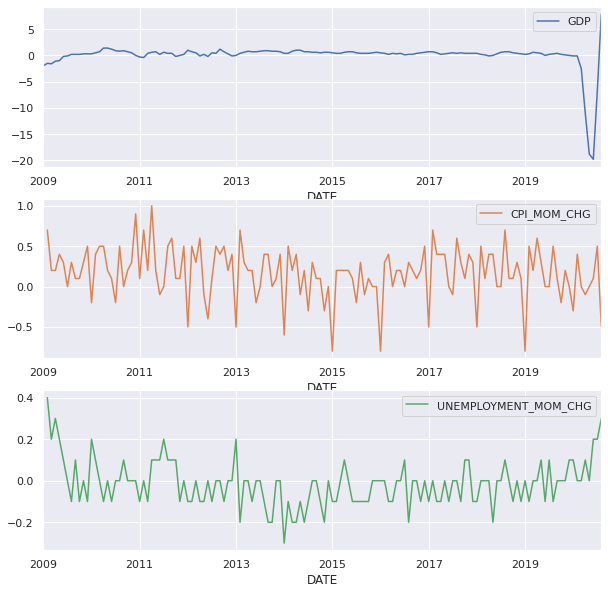

In [71]:
target_df[["GDP", "CPI_MOM_CHG", "UNEMPLOYMENT_MOM_CHG"]].plot(subplots=True, figsize=(10,10), sharex=False)

In [72]:
target_df = target_df.reset_index()
target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   DATE                  140 non-null    datetime64[ns]
 1   CPI                   140 non-null    float64       
 2   UNEMPLOYMENT          140 non-null    float64       
 3   GDP                   140 non-null    float64       
 4   UNEMPLOYMENT_MOM_CHG  139 non-null    float64       
 5   CPI_MOM_CHG           139 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 6.7 KB


In [4]:
from cross_validate import cross_validate, build_design_matrix, evaluate_features

### Target: 3M on 3M GDP Change, Inflation and Unemployment Rate

In [74]:
from sklearn.linear_model import LinearRegression

lr=LinearRegression()

results_df = pd.DataFrame()
for target_col in ["GDP", "CPI_MOM_CHG", "UNEMPLOYMENT_MOM_CHG"]:
    print(f"Forecast for {target_col}:")
    rmse_list = []
    design_df_list = []
    result_df_list = []
    for horizon in [1,2,3,4,5,6]:
        design_df, result_df = evaluate_features(
            target_df[["DATE", target_col]],
            date_col="DATE",
            var_col=target_col,
            horizon=horizon,
            estimator=lr,
            window=36,
            period=1,
            return_model=True,
            start_date="2013-12-01",
            end_date="2020-08-01",
        )
        # add metadata to result_df     
        result_df["horizon"] = horizon
        result_df["target"] = target_col
        rmse = (((result_df["pred"] - result_df["actual"]) ** 2).mean()) ** 0.5
        rmse_list.append(rmse)
        design_df_list.append(design_df)
        result_df_list.append(result_df)
        print(f"Average RMSE over {len(result_df)} predictions for {horizon}-month horizon: {rmse:.3f}")

    # concat the result_df_list for different targets
    results_df = pd.concat(result_df_list + [results_df])
    print(f"\nAverage RMSE across different horizons: {np.array(rmse_list).mean():.3f}\n")

Forecast for GDP:
Average RMSE over 42 predictions for 1-month horizon: 19.273
Average RMSE over 40 predictions for 2-month horizon: 25.996
Average RMSE over 38 predictions for 3-month horizon: 8.194
Average RMSE over 36 predictions for 4-month horizon: 5.379
Average RMSE over 34 predictions for 5-month horizon: 5.498
Average RMSE over 32 predictions for 6-month horizon: 5.660

Average RMSE across different horizons: 11.667

Forecast for CPI_MOM_CHG:
Average RMSE over 42 predictions for 1-month horizon: 0.328
Average RMSE over 40 predictions for 2-month horizon: 0.326
Average RMSE over 38 predictions for 3-month horizon: 0.332
Average RMSE over 36 predictions for 4-month horizon: 0.333
Average RMSE over 34 predictions for 5-month horizon: 0.314
Average RMSE over 32 predictions for 6-month horizon: 0.346

Average RMSE across different horizons: 0.330

Forecast for UNEMPLOYMENT_MOM_CHG:
Average RMSE over 42 predictions for 1-month horizon: 0.098
Average RMSE over 40 predictions for 2-mon

In [75]:
results_df["target"].value_counts()

CPI_MOM_CHG             222
UNEMPLOYMENT_MOM_CHG    222
GDP                     222
Name: target, dtype: int64

<AxesSubplot:xlabel='date', ylabel='3M on 3M GDP Change'>

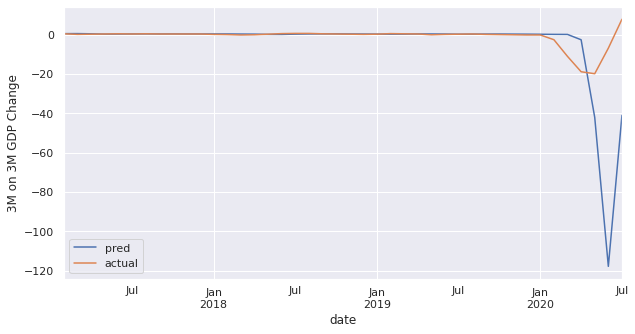

In [77]:
# check GDP 1-month horizon plot for 
gdp_result_df = results_df.loc[(results_df["target"] == "GDP") & (results_df["horizon"] == 1)]
gdp_result_df[["pred", "actual", "date"]].set_index("date").plot(figsize=(10,5), ylabel="3M on 3M GDP Change")

In [79]:
results_df.to_csv("baseline_result.csv", index=False)